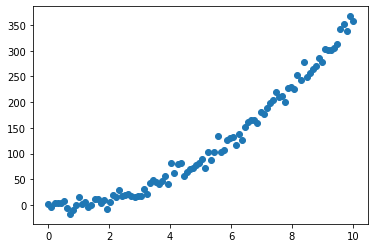

In [31]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(0.0,10.0, num=100)
a = 4.0
b = -3.5
c = 0.0
y = (a*(x**2)) + (b*x) + c

#   let's add noise to the data
#   np.random.normal(mean, standardDeviation, num)
noise = np.random.normal(0, 10., 100)
y = y+noise
plt.scatter(x,y)

Now onto the formulation of the likelihood equation that we'll use to determine coefficients of a fitted polynomial.
Linear regression is generally of some form
$$
\mathbf{Y}=\mathbf{X} \beta+\mathbf{r}
$$
for a true function $\mathbf{Y}$, the matrix of independent variables $\mathbf{X}$, the model coefficients $\beta$, and some residual difference between the true data and the model $\mathbf{r}$. For a second order polynomial, $\mathbf{X}$ is of the form $\mathbf{X}=\left[\mathbf{1}, \mathbf{x}, \mathbf{x}^{\mathbf{2}}\right]$. We can rewrite the equation of linear regression as
$$
\mathbf{r}=\mathbf{Y}-\mathbf{X} \beta
$$
where the residuals $\mathbf{r}$ are expressed as the difference between the true model ( $\mathbf{Y})$ and the linear model $(\mathbf{X} \beta)$. If we assume the data to be of an independent and identically distributed sample, and that the residual $\mathbf{r}$ is from a normal (Gaussian) distribution, then we'll get the following probability density function $f$.
$$
f\left(x \mid \mu, \sigma^2\right)=\left(2 \pi \sigma^2\right)^{-\frac{n}{2}} \exp \left(-\frac{(x-\mu)^2}{2 \sigma^2}\right)
$$
The probability density function $f\left(x \mid \mu, \sigma^2\right)$ is for a point $x$, with a mean $\mu$, and standard deviation $\sigma$. If we substitute the residual into the equation, and assume that the residual will have a mean of zero $(\mu=0)$ we get

The probability density function $f\left(x \mid \mu, \sigma^2\right)$ is for a point $x$, with a mean $\mu$, and standard deviation $\sigma$. If we substitute the residual into the equation, and assume that the residual will have a mean of zero $(\mu=0)$ we get
$$
f\left(r \mid 0, \sigma^2\right)=\left(2 \pi \sigma^2\right)^{-\frac{n}{2}} \exp \left(-\frac{(y-x \beta)^2}{2 \sigma^2}\right)
$$
which defines the probability density function for a given point. The likelihood function $L$ is defined as
$$
L\left(\beta \mid x_1, x_2, \cdots, x_n\right)=\prod_{i=1}^n f\left(x_i \mid \beta\right)
$$
the multiplication of all probability densities at each $x_i$ point. When we substitute the probability density function into the definition of the maximum likelihood function, we have the following.
$$
L\left(\beta \mid x_1, x_2, \cdots, x_n\right)=\left(2 \pi \sigma^2\right)^{\frac{n}{2}} \exp \left(-\frac{(\mathbf{Y}-\mathbf{X} \beta)^{\mathrm{T}}(\mathbf{Y}-\mathbf{X} \beta)}{2 \sigma^2}\right)
$$
It is practical to work with the log-likelihood as opposed to the likelihood equation as the likelihood equation can be nearly zero. In Python we have created a function which returns the log-likelihood value given a set of 'true' values ( $\mathbf{Y})$ and a set of 'guess' values $\mathbf{X} \beta$.

In [2]:
#   define a function to calculate the log likelihood
def calcLogLikelihood(guess, true, n):
    error = true-guess
    sigma = np.std(error)
    f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
        np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    return np.log(f)

Optimization is used to determine which parameters $\beta$ maximize the loglikelihood function. The optimization problem is expressed below.
$$
\left\{\hat{\beta}_{\mathrm{MLE}}\right\} \subseteq\left\{\arg \max \ln \left(L\left(\beta \mid x_1, x_2, \cdots, x_n\right)\right)\right\}
$$
So since our data originates from a second order polynomial, let's fit a second order polynomial to the data. First we'll have to define a function which will calculate the log likelihood value of the second order polynomial for three different coefficients ('var').

In [3]:
#   define my function which will return the objective function to be minimized
import math
def myFunction(var):
    #   load my  data
    #[x, y] = np.load('myData.npy')
    yGuess = (var[2]*(x**2)) + (var[1]*x) + var[0]
    f = calcLogLikelihood(yGuess, y, float(len(yGuess)))
    return (-1*f)

We can then use gradient-based optimization to find which polynomial coefficients maximize the log-likelihood. I used scipy and the BFGS algorithm, but other algorithms and optimization methods should work well for this simple problem. I picked some random variable values to start the optimization. The Python code to run the scipy optimizer is presented in the following lines. Note that maximizing the likelihood is the same as minimizing minus 1 times the likelihood.

In [4]:
#  Let's pick some random starting points for the optimization    
nvar = 3
var = np.zeros(nvar)
var[0] = -5
var[1] = -6
var[2] = 1

#   let's maximize the likelihood (minimize -1*max(likelihood)
from scipy.optimize import minimize
res = minimize(myFunction, var, method='BFGS',options={'disp': True})
res

Optimization terminated successfully.
         Current function value: 377.378634
         Iterations: 12
         Function evaluations: 88
         Gradient evaluations: 22


      fun: 377.3786344092195
 hess_inv: array([[ 9.55699932, -3.77789163,  0.31171363],
       [-3.77789163,  2.04226064, -0.19259223],
       [ 0.31171363, -0.19259223,  0.01951958]])
      jac: array([ 0.00000000e+00, -3.81469727e-06, -7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 88
      nit: 12
     njev: 22
   status: 0
  success: True
        x: array([-0.06389534, -3.99665417,  4.09750848])

As it turns out, with the assumptions we have made (Gaussian distribution, independent and identically distributed, μ=0
) the result of maximizing the likelihood should be the same as performing a least squares fit. So let’s go ahead and perform a least squares fit to determine the coefficients of a second order polynomial from the data points. This can be done with scikit-learn easily with the following lines of Python code.

In [5]:
#   perform least squares fit using scikitlearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression(fit_intercept=False))])

#model = model.fit(x[:, np.newaxis], y)
model = model.fit(x.reshape(-1,1),y)
coefs = model.named_steps['linear'].coef_
coefs

array([-0.06391075, -3.99664724,  4.09750788])

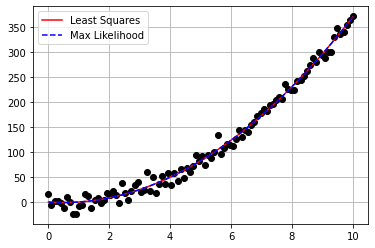

In [6]:
#   plot the data and model fits
plt.figure()
plt.plot(x,y, 'ok')
plt.plot(x,model.predict(x[:,np.newaxis]), '-r', label='Least Squares')
plt.plot(x,(res.x[2]*(x**2)) + (res.x[1]*x) + res.x[0], '--b', label='Max Likelihood')
plt.grid(True)
plt.legend(loc=2)
plt.show()
#plt.savefig('maxLikelihoodComp.png', dpi=300, type='png')


In [41]:
# Using Autograd to calculate gradients for OLS
from random import random, seed
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import grad

def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

n = 100
#x = 2*np.random.rand(n,1)
#y = 4+3*x+np.random.randn(n,1)
xx = np.power(x,2)

X = np.c_[np.ones((n,1)), x, xx]


# OLS

In [42]:
XT_X = X.T @ X
theta_linreg = np.linalg.pinv(XT_X) @ (X.T @ y)
print("Own inversion")
print(theta_linreg)
# Hessian matrix
H = (2.0/n)* XT_X
EigValues, EigVectors = np.linalg.eig(H)
print(f"Eigenvalues of Hessian Matrix:{EigValues}")

Own inversion
[[-1.96581529]
 [-0.7552064 ]
 [ 3.70625048]]
Eigenvalues of Hessian Matrix:[4.12466600e+03 1.98055138e-01 4.81270845e+00]


# Gradient with autograd

In [43]:
y = y.reshape(-1,1)
print(X.shape,y.shape)

(100, 3) (100, 1)


In [44]:
theta = np.random.randn(3,1)
eta = 1.0/np.max(EigValues)
Niterations = 1000
# define the gradient
training_gradient = grad(CostOLS)

In [45]:
for iter in range(Niterations):
    gradients = training_gradient(theta)
    theta -= eta*gradients
print("theta from own gd")
print(theta)

theta from own gd
[[-1.0320108 ]
 [-0.60920475]
 [ 3.67261333]]


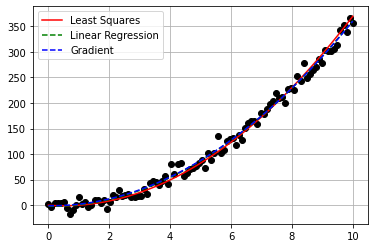

In [46]:
#   plot the data and model fits
plt.figure()
plt.plot(x,y, 'ok')
plt.plot(x,model.predict(x[:,np.newaxis]), '-r', label='Least Squares')
plt.plot(x,(theta_linreg[2]*(x**2)) + (theta_linreg[1]*x) + theta_linreg[0], '--g', label='Linear Regression')
plt.plot(x,(theta[2]*(x**2)) + (theta[1]*x) + theta[0], '--b', label='Gradient')
plt.grid(True)
plt.legend(loc=2)
plt.show()